In [11]:
import xarray as xr
import numpy as np
import rioxarray as rioxr
import rasterio
from rasterio.transform import from_bounds
import pandas as pd
import os

In [ ]:
ex = xr.open_dataset('dataset_source-era5_date-2022-01-01_res-0.25_levels-13_steps-12.nc')

C:\Users\dylan\AppData\Local\Temp\ipykernel_5192\1561063605.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ex = xarr.open_dataset('dataset_source-era5_date-2022-01-01_res-0.25_levels-13_steps-12.nc')


In [19]:
ex

<xarray.Dataset> Size: 307MB
Dimensions:                       (lon: 360, lat: 181, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 1kB 0.0 1.0 2.0 ... 358.0 359.0
  * lat                           (lat) float32 724B -90.0 -89.0 ... 89.0 90.0
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 261kB ...
    land_sea_mask                 (lat, lon) float32 261kB ...
    2m_temperature                (batch, time, lat, lon) float32 4MB ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 4MB ...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 4MB ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 4MB ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 47MB ...
    geopotential                  (batch, time, level, lat, lon) float32 47MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 47MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 47MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 47MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 47MB ...

In [20]:
ex['datetime'].values

array([['2022-01-01T00:00:00.000000000', '2022-01-01T06:00:00.000000000',
        '2022-01-01T12:00:00.000000000', '2022-01-01T18:00:00.000000000',
        '2022-01-02T00:00:00.000000000', '2022-01-02T06:00:00.000000000',
        '2022-01-02T12:00:00.000000000', '2022-01-02T18:00:00.000000000',
        '2022-01-03T00:00:00.000000000', '2022-01-03T06:00:00.000000000',
        '2022-01-03T12:00:00.000000000', '2022-01-03T18:00:00.000000000',
        '2022-01-04T00:00:00.000000000', '2022-01-04T06:00:00.000000000']],
      dtype='datetime64[ns]')

In [4]:
accum = xr.open_dataset('valid_single/data_stream-oper_stepType-accum.nc')

In [ ]:
accum

<xarray.Dataset> Size: 33MB
Dimensions:     (valid_time: 4, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 32B 2025-06-30 ... 2025-06-30T18:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 64B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 17MB ...
    tisr        (valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-18T14:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
print(accum.dims)
#     # print(accum.values)
# print(accum['tp'].dims)
# print(accum['tp'][0].values)

FrozenMappingWarningOnValuesAccess({'valid_time': 4, 'latitude': 721, 'longitude': 1440})


In [ ]:
ins = xarr.open_dataset('june30_single_25km/data_stream-oper_stepType-instant.nc')

In [ ]:
ins

<xarray.Dataset> Size: 100MB
Dimensions:     (valid_time: 4, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 32B 2025-06-30 ... 2025-06-30T18:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 64B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 17MB ...
    v10         (valid_time, latitude, longitude) float32 17MB ...
    t2m         (valid_time, latitude, longitude) float32 17MB ...
    msl         (valid_time, latitude, longitude) float32 17MB ...
    z           (valid_time, latitude, longitude) float32 17MB ...
    lsm         (valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-18T14:43 GRIB to CDM+CF via cfgrib-0.9.1...

#### We first merge the files with instant measurements and the files with accumulated measurements (accumulated precipitation) into one file for each day in the 'single' directory. 

In [ ]:
def merge_single_ins_accum(input_folder, output_folder):
    # era data has subfolders for each downloaded single-level dataset and each pressure-level dataset 
    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)
        # instant precipitation
        ins = xr.open_dataset(subfolder_path+'/data_stream-oper_stepType-instant.nc')
        accum = xr.open_dataset(subfolder_path + '/data_stream-oper_stepType-accum.nc')
        # add the variables in the instant dataset into the accumulated dataset
        accum['10m_u_component_of_wind'] = ins['u10']
        accum['10m_v_component_of_wind'] = ins['v10']
        accum['2m_temperature'] = ins['t2m']
        accum['mean_sea_level_pressure'] = ins['msl']
        accum['geopotential_at_surface'] = ins['z']
        accum['land_sea_mask'] = ins['lsm']
        accum = accum.rename({'tp':'total_precipitation_6hr'})
        accum = accum.rename({'tisr': 'toa_incident_solar_radiation'})
        accum = accum.rename({'valid_time': 'datetime','longitude': 'lon', 'latitude': 'lat'})
        # write accum dataset as a file to the 'single' folder within the 'converted' folder dataset
        # we name the output file the same name as the subfolder
        output_file = subfolder
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        output_path = f"{output_folder}/{output_file}.nc"
        accum.to_netcdf(path = output_path, mode = "w")
        accum.close()
        ins.close()

In [7]:
merge_single_ins_accum('valid_single', 'merged_val_sin')

#### Now merge the three single level files into one file

In [ ]:
def merge_single(input_folder, output_folder):
    if os.path.isdir(input_folder):
        # first merge the two components of instant data and accumulated data together (merge_single_ins_accum does this for each file in input_folder)
        merge_single_ins_accum(input_folder, output_folder)
    else:
        os.mkdir(input_folder)
        print("Add single-level files to input folder")
        return
    
    files = [os.path.join(output_folder, file) for file in os.listdir(output_folder)]
    datasets = [xr.open_dataset(file) for file in files]
    # we want to merge the 'datetime' dimensions of all files into a single file 
    merged = xr.concat(datasets, dim='datetime')
    # make sure the datetime dims are sorted
    merged = merged.sortby('datetime')
    output_path = os.path.join(output_folder, 'single_levels.nc')
    print(f"The merged file: \'single_levels.nc\' has been created in {output_folder}")
    merged.to_netcdf(output_path, mode = "w")
    for ds in datasets:
        ds.close()
    

In [12]:
merge_single(input_folder = 'single', output_folder = 'merged_single')

The merged file: 'single_levels.nc' has been created in merged_single


#### Merge the pressure level files into one file of pressure levels

In [13]:
os.listdir('pressure')

['july1_2_pressure_25km.nc',
 'july3_pressure_25km.nc',
 'june30_pressure_25km.nc']

In [8]:
def merge_pressure(input_folder, output_folder):
    if os.path.isdir(input_folder):
        files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]
        dsets = []
        for file in files:
            ds = xr.open_dataset(file)
            # rename the dimensions
            ds = ds.rename({'pressure_level': 'level','valid_time': 'datetime','longitude': 'lon', 'latitude': 'lat'})
            # rename the variables
            ds = ds.rename({'z':'geopotential', 'q': 'specific_humidity', 't': 'temperature', 'u': 'u_component_of_wind',
                            'v': 'v_component_of_wind', 'w': 'vertical_velocity'})
            dsets.append(ds)
        merged = xr.concat(dsets, dim='datetime')
        merged = merged.sortby('datetime')   
        output_path = os.path.join(output_folder, 'pressure_levels.nc')
        merged.to_netcdf(output_path, mode = "w")
        merged.close()
        for ds in dsets:
            ds.close()
        print(f"The merged file: \'pressure_levels.nc\' has been created in {output_folder}")
    else:
        os.mkdir(input_folder)
        print("Add single-level files to input folder")
        return

In [12]:
def set_pressure(file, output_file):
    ds = xr.open_dataset(file)
    # rename the dimensions
    ds = ds.rename({'pressure_level': 'level','valid_time': 'datetime','longitude': 'lon', 'latitude': 'lat'})
    # rename the variables
    ds = ds.rename({'z':'geopotential', 'q': 'specific_humidity', 't': 'temperature', 'u': 'u_component_of_wind',
                    'v': 'v_component_of_wind', 'w': 'vertical_velocity'})
    ds.sortby('datetime')
    ds.to_netcdf(output_file, mode = "w")
    ds.close()

In [13]:
set_pressure('valid_pressure.nc', 'jul_3-5_pres.nc')

In [14]:
merge_pressure(input_folder = 'pressure', output_folder = 'merged_pressure')

The merged file: 'pressure_levels.nc' has been created in merged_pressure


In [ ]:
pres = xr.open_dataset('merged_pressure/pressure_levels.nc')

In [17]:
pres
# pres.close()

<xarray.Dataset> Size: 5GB
Dimensions:              (lon: 1440, lat: 721, datetime: 14, level: 13)
Coordinates:
  * lon                  (lon) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                  (lat) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
    expver               (datetime) object 112B ...
  * datetime             (datetime) datetime64[ns] 112B 2025-06-30 ... 2025-0...
  * level                (level) float64 104B 1e+03 925.0 850.0 ... 100.0 50.0
    number               int32 4B ...
Data variables:
    geopotential         (datetime, level, lat, lon) float32 756MB ...
    specific_humidity    (datetime, level, lat, lon) float32 756MB ...
    temperature          (datetime, level, lat, lon) float32 756MB ...
    u_component_of_wind  (datetime, level, lat, lon) float32 756MB ...
    v_component_of_wind  (datetime, level, lat, lon) float32 756MB ...
    vertical_velocity    (datetime, level, lat, lon) float32 756MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-18T14:28 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
single = xr.open_dataset('merged_single\single_levels.nc')

In [20]:
single
# print(single.dims)
# print(single['datetime'])
# single.close()

<xarray.Dataset> Size: 465MB
Dimensions:                       (lon: 1440, lat: 721, datetime: 14)
Coordinates:
  * lon                           (lon) float64 12kB 0.0 0.25 ... 359.5 359.8
  * lat                           (lat) float64 6kB 90.0 89.75 ... -89.75 -90.0
    expver                        (datetime) object 112B ...
  * datetime                      (datetime) datetime64[ns] 112B 2025-06-30 ....
    number                        int32 4B ...
Data variables:
    total_precipitation_6hr       (datetime, lat, lon) float32 58MB ...
    toa_incident_solar_radiation  (datetime, lat, lon) float32 58MB ...
    10m_u_component_of_wind       (datetime, lat, lon) float32 58MB ...
    10m_v_component_of_wind       (datetime, lat, lon) float32 58MB ...
    2m_temperature                (datetime, lat, lon) float32 58MB ...
    mean_sea_level_pressure       (datetime, lat, lon) float32 58MB ...
    geopotential_at_surface       (datetime, lat, lon) float32 58MB ...
    land_sea_mask                 (datetime, lat, lon) float32 58MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-18T14:45 GRIB to CDM+CF via cfgrib-0.9.1...

#### Merge the single level file with the pressure-levels file. The single level file has variables that are taken at the surface level. The pressure level file has corresponding variables but with 13 added dimensions for each pressure level.

In [9]:
def merge_single_pres(single_file, pres_file, output_file):
    single = xr.open_dataset(single_file)
    pres = xr.open_dataset(pres_file)
    assert np.array_equal(single['datetime'].values, pres['datetime'].values)
    merged = xr.merge([single, pres])
    merged.to_netcdf(output_file)
    single.close()
    pres.close()
    merged.close()

In [14]:
merge_single_pres('merged_val_sin/valid_jul_3-5.nc', 'jul_3-5_pres.nc', 'valid_jul_3-5.nc')

In [ ]:
merge_single_pres('merged_single/single_levels.nc', 'merged_pressure/pressure_levels.nc', 'meerged.nc')

Now we want to write the merged dataset into GraphCast's example dataset (25km, 13 pressure leveles) where the values in the example dataset have been set to 0 

* Notice that the merged dataset has extra dimensions of 'datetime' for the variables of 'geopotential_at_surface' and 'landseamask' while the GraphCast source dataset does not include a time dimension for these variables. So we will use only the first datetime dimension in the merged dataset (this would represent the geopotential values for the first time step on June 30)
* The source dataset includes one extra 'batch' dimension for the variables. 
* The source dataset uses a time dimension with dtype timedelta64[ns] while the merged dataset uses datetime64[ns]

In [ ]:
def merged_to_template_file(merged_path, source_path): 
    merged = xr.open_dataset(merged_path)
    source = xr.open_dataset(source_path)

    # Add a 'batch' and 'time' coordinate. 'time' is the form of 'datetime' converted to dtype timedelta64[ns]
    merged = merged.rename_dims({'datetime': 'time'})
    ref_time = merged['datetime'].values[0]
    time_values = merged['datetime'].values - ref_time
    merged = merged.assign_coords(time=time_values)
    assert(merged['datetime'].shape == merged['time'].shape)

    for var in merged.data_vars:
        if var not in ['geopotential_at_surface', 'land_sea_mask']:
            # There is a step size of 14 for the 12 step period
            merged[var] = merged[var].expand_dims({'batch': 1})

    merged.drop_vars(['expver', 'number'])
    merged['geopotential_at_surface'] = merged['geopotential_at_surface'][0]
    merged['land_sea_mask'] = merged['land_sea_mask'][0]


    # source is used as the file template for graphCast data 
    # Write the value in merged into source 
    for var in source.data_vars:
        assert source[var].shape == merged[var].shape , f"Datasets do not match: {var, source[var].shape, merged[var].shape}"
        source[var].values[:] = merged[var].values[:]

    # write to file 
    source.to_netcdf('era_25km.nc')
    print('The merged file has been converted to the graphCast template \'era_25km\'')
    merged.close()
    source.close()

### ----------------------------------------------------------------------------

### Create another file for 100 km resolution

In [2]:
input_25km = xr.open_dataset('era_25km.nc')

C:\Users\dylan\AppData\Local\Temp\ipykernel_3336\150726157.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  input_25km = xr.open_dataset('era_25km.nc')


In [3]:
input_25km

<xarray.Dataset> Size: 5GB
Dimensions:                       (lon: 1440, lat: 721, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 4MB ...
    land_sea_mask                 (lat, lon) float32 4MB ...
    2m_temperature                (batch, time, lat, lon) float32 58MB ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 58MB ...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 58MB ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 58MB ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 756MB ...
    geopotential                  (batch, time, level, lat, lon) float32 756MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 756MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 756MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 756MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 756MB ...

In [9]:
input_25km['lon']

<xarray.DataArray 'lon' (lon: 1440)> Size: 6kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  longitude
    units:      degrees_east

In [3]:
input_25km

<xarray.Dataset> Size: 5GB
Dimensions:                       (lon: 1440, lat: 721, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 4MB ...
    land_sea_mask                 (lat, lon) float32 4MB ...
    2m_temperature                (batch, time, lat, lon) float32 58MB ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 58MB ...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 58MB ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 58MB ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 756MB ...
    geopotential                  (batch, time, level, lat, lon) float32 756MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 756MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 756MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 756MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 756MB ...

In [3]:
input_100km = input_25km.coarsen(lat=4, lon=4, boundary='trim', coord_func = 'mean').mean()

In [8]:
input_100km['lat'].shape

(180,)

In [11]:
input_100km

<xarray.Dataset> Size: 305MB
Dimensions:                       (lat: 180, lon: 360, batch: 1, time: 14,
                                   level: 13)
Coordinates:
  * lon                           (lon) float32 1kB 0.375 1.375 ... 358.4 359.4
  * lat                           (lat) float32 720B -89.62 -88.62 ... 89.38
  * time                          (time) timedelta64[ns] 112B 0 days 00:00:00...
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 112B 2022-01-0...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 259kB -1.894 ... 2.68e+04
    land_sea_mask                 (lat, lon) float32 259kB 0.0 0.0 ... 1.0 1.0
    2m_temperature                (batch, time, lat, lon) float32 4MB 273.8 ....
    mean_sea_level_pressure       (batch, time, lat, lon) float32 4MB 1.015e+...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 4MB 2.184 ....
    10m_u_component_of_wind       (batch, time, lat, lon) float32 4MB 0.7138 ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 47MB ...
    geopotential                  (batch, time, level, lat, lon) float32 47MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 47MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 47MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 47MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 47MB ...

In [9]:
valid_100km = xr.open_dataset('source-era5_date-2022-01-01_res-1.0_levels-13_steps-12.nc')

C:\Users\dylan\AppData\Local\Temp\ipykernel_19928\275630392.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  valid_100km = xr.open_dataset('source-era5_date-2022-01-01_res-1.0_levels-13_steps-12.nc')


In [11]:
valid_100km.dims['lat'], valid_100km.dims['lon']

C:\Users\dylan\AppData\Local\Temp\ipykernel_19928\3887266093.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  valid_100km.dims['lat'], valid_100km.dims['lon']


(181, 360)

In [12]:
valid_100km['lat'].values

array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  6

In [13]:
len(np.arange(-90, 91, 1.0))

181

In [15]:
def generate_100km(path_25km: str, out_path_100km: str):
    
    input_25km = xr.open_dataset(path_25km)
    
    # Coarsen by a factor of 4 to get 100km resolution
    input_100km = input_25km.coarsen(lat=4, lon=4, boundary='pad', coord_func = 'mean').mean()
    
    # new_lat: [-90,90]    new_lon: [0, 359]
    new_lat = np.arange(-90, 91, 1.0)
    new_lon = np.arange(0, 360, 1.0)
    
    # Assign new coordinates (interpolates if needed)
    input_100km = input_100km.assign_coords(
        lat=new_lat,
        lon=new_lon
    )
    
    input_100km.to_netcdf(out_path_100km)
    input_100km.close()
    input_25km.close()

In [17]:
generate_100km('valid_jul_3-5.nc', 'valid_100km.nc')

In [24]:
generate_100km('era_25km.nc', 'input_100km.nc')

C:\Users\dylan\AppData\Local\Temp\ipykernel_19928\730547636.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  input_25km = xr.open_dataset(path_25km)


Visualize June 30 - July 2 Accumulated Precipitation

In [4]:
input_25km = xr.open_dataset('era_25km.nc')

C:\Users\dylan\AppData\Local\Temp\ipykernel_14948\150726157.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  input_25km = xr.open_dataset('era_25km.nc')


In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [12]:
data = input_25km.total_precipitation_6hr

In [10]:
data

<xarray.DataArray 'total_precipitation_6hr' (batch: 1, time: 14, lat: 721,
                                             lon: 1440)> Size: 58MB
array([[[[1.525879e-05, ..., 1.525879e-05],
         ...,
         [0.000000e+00, ..., 0.000000e+00]],

        ...,

        [[1.096725e-05, ..., 1.096725e-05],
         ...,
         [1.430511e-06, ..., 1.430511e-06]]]], dtype=float32)
Coordinates:
  * lon       (lon) float32 6kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat       (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time      (time) timedelta64[ns] 112B 0 days 00:00:00 ... 3 days 06:00:00
    datetime  (batch, time) datetime64[ns] 112B ...
Dimensions without coordinates: batch

In [48]:
import math
from typing import Optional

In [76]:
# from graphcast_demo.ipynb (graphCast repo)
def select(
    data: xr.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xr.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data


def scale(
    data: xr.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xr.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"),
        label="m")
    images.append(im)


In [62]:
# plot july 3, hour 6 (the last time index in input_25km)
july_3 = input_25km.isel(time= -1)
# modify the dataset to only include the Texas region
july_3_tx = july_3.sel(
    lat=slice(27, 36.5),
    lon=slice(254, 266)
)

In [ ]:
july_3

<xarray.Dataset> Size: 658kB
Dimensions:                       (lon: 49, lat: 39, level: 13, batch: 1)
Coordinates:
  * lon                           (lon) float32 196B 254.0 254.2 ... 265.8 266.0
  * lat                           (lat) float32 156B 27.0 27.25 ... 36.25 36.5
    time                          timedelta64[ns] 8B 3 days 06:00:00
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
    datetime                      (batch) datetime64[ns] 8B ...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 8kB ...
    land_sea_mask                 (lat, lon) float32 8kB ...
    2m_temperature                (batch, lat, lon) float32 8kB ...
    mean_sea_level_pressure       (batch, lat, lon) float32 8kB ...
    10m_v_component_of_wind       (batch, lat, lon) float32 8kB ...
    10m_u_component_of_wind       (batch, lat, lon) float32 8kB ...
    ...                            ...
    temperature                   (batch, level, lat, lon) float32 99kB ...
    geopotential                  (batch, level, lat, lon) float32 99kB ...
    u_component_of_wind           (batch, level, lat, lon) float32 99kB ...
    v_component_of_wind           (batch, level, lat, lon) float32 99kB ...
    vertical_velocity             (batch, level, lat, lon) float32 99kB ...
    specific_humidity             (batch, level, lat, lon) float32 99kB ...

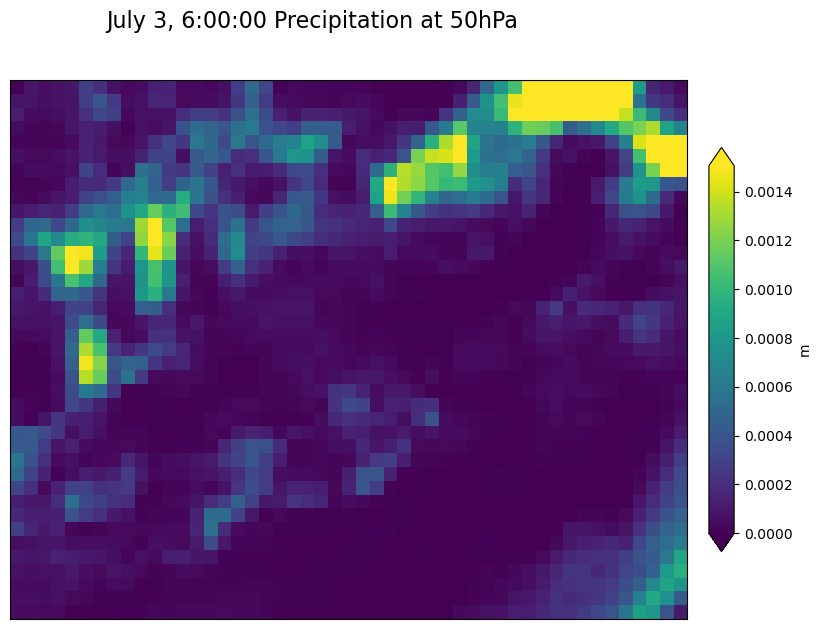

In [77]:
# from GraphCast demo, we use july_3 as the dataset, precipitation as the variable, level 50, and time step of 1 
plot_size = 7

data = {
    " ": scale(select(july_3_tx, 'total_precipitation_6hr', 50, 1),
              robust=True),
}
fig_title = "July 3, 6:00:00 Precipitation at 50hPa"

plot_data(data, fig_title, plot_size, True)

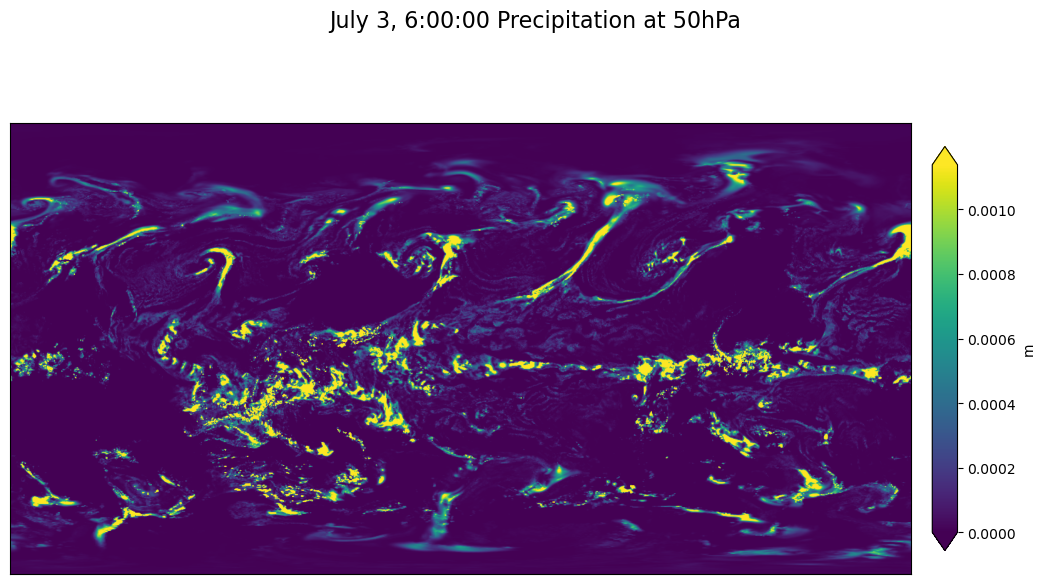

In [78]:
plot_size = 7

data = {
    " ": scale(select(july_3, 'total_precipitation_6hr', 50, 1),
              robust=True),
}
fig_title = "July 3, 6:00:00 Precipitation at 50hPa"

plot_data(data, fig_title, plot_size, True)